# Imports

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [5]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [7]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

## Learn H, A, T from Austin

In [8]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

### Transfer learning with A_au

In [27]:
from scipy.optimize import nnls

pred_transfer = {}
T_adapt = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'


for random_seed in range(10):
    pred_transfer[random_seed] = {}
    T_adapt[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
for random_seed in range(1):
    print "random seed: ", random_seed
    for adapt_percentage in range(10, 110, 10):
        print "adapt percentage: ", adapt_percentage
        rd = 0
        T_adapt[random_seed][adapt_percentage] = {}
        for adapt_max, test in kf.split(sd_df):
            print "round: ", rd
            
            
            num_adapt = int((adapt_percentage*len(adapt_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if adapt_percentage == 100:
                adapt = adapt_max
            else:
                adapt, _ = train_test_split(adapt_max, train_size = adapt_percentage/100.0, random_state=random_seed)
            
            # get the index of training and testing data
            adapt_ix = sd_df.index[adapt]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            adapt_df = sd_df.ix[adapt_ix]
            test_df = sd_df.ix[test_ix]
            adapt_dfc = sd_dfc.ix[adapt_ix]
            test_dfc = sd_dfc.ix[test_ix]
            adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)
            
            # use the adpat data with A_au from Austion to learn T_sd_adapt
            H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT(case, adapt_sd_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)

            T_adapt[random_seed][adapt_percentage][rd] = T_sd_adapt
            rd += 1
            
#             # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
#             test_sd_tensor = get_tensor(test_df, test_dfc)
#             # Get the aggregate information of test homes
#             aggregate_test = test_sd_tensor[:, 0, :]
#             # Use A_au from Austin and T_sd_adapt learn previous
#             AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)
            
#             # Estimate Home factor H_test_mat for test homes
#             H_test_mat = np.zeros((len(test_df), 2))
#             for j in range(len(test_df)):
#                 mask_rows = pd.Series(aggregate_test[j,:]).notnull()
#                 H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
#             pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)
            
#             for appliance_name, appliance_id in appliance_index.iteritems():
#                 pred_transfer[random_seed][appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))
            

random seed:  0
adapt percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
adapt percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:

In [25]:
T = T_adapt[0][10][0]
for i in range(1, 10):
    T = T + T_adapt[0][10][i]
T = T/10
T

array([[ 2.32479311,  0.15576316],
       [ 2.24096214,  0.16500582],
       [ 2.21518465,  0.18727954],
       [ 2.47576652,  0.28357593],
       [ 2.38588448,  1.73382149],
       [ 2.59029297,  1.64217154],
       [ 1.54119135,  3.03091597],
       [ 1.7041817 ,  3.91344342],
       [ 1.87733896,  3.73096729],
       [ 1.98019617,  2.16731981],
       [ 2.42965187,  0.47091583],
       [ 2.38565282,  1.42824386]])

In [53]:
# T = []*10
T = []

for i in range(10, 110, 10):
    T_temp = T_adapt[0][i][0]
    # get average of 10 folds
    for j in range(1, 10):
        T_temp = T_temp + T_adapt[0][i][j]
    T_temp = T_temp/10
    T.append(T_temp)


In [54]:
T

[array([[ 2.32479311,  0.15576316],
        [ 2.24096214,  0.16500582],
        [ 2.21518465,  0.18727954],
        [ 2.47576652,  0.28357593],
        [ 2.38588448,  1.73382149],
        [ 2.59029297,  1.64217154],
        [ 1.54119135,  3.03091597],
        [ 1.7041817 ,  3.91344342],
        [ 1.87733896,  3.73096729],
        [ 1.98019617,  2.16731981],
        [ 2.42965187,  0.47091583],
        [ 2.38565282,  1.42824386]]), array([[ 2.895822  ,  0.01104774],
        [ 2.67787815,  0.01199504],
        [ 2.7916607 ,  0.04178044],
        [ 2.90351927,  0.08577374],
        [ 2.46529406,  1.80153495],
        [ 2.66716004,  1.47941904],
        [ 1.84162607,  3.51576468],
        [ 1.89148046,  4.05535419],
        [ 2.28488866,  3.95705241],
        [ 2.52991198,  1.85186797],
        [ 2.94987608,  0.11814282],
        [ 3.43205278,  0.52988286]]), array([[ 3.08853121,  0.01964045],
        [ 2.84810458,  0.01870567],
        [ 3.07622239,  0.05058041],
        [ 3.153088  ,  0.1

In [59]:
k = T[0].reshape(1, 24)
for i in range(1, 10):
    k = np.r_[k, T[i].reshape(1,24)]
df_T = pd.DataFrame(k)

In [67]:
df_T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,2.324793,0.155763,2.240962,0.165006,2.215185,0.187280,2.475767,0.283576,2.385884,1.733821,...,1.704182,3.913443,1.877339,3.730967,1.980196,2.167320,2.429652,0.470916,2.385653,1.428244
1,2.895822,0.011048,2.677878,0.011995,2.791661,0.041780,2.903519,0.085774,2.465294,1.801535,...,1.891480,4.055354,2.284889,3.957052,2.529912,1.851868,2.949876,0.118143,3.432053,0.529883
2,3.088531,0.019640,2.848105,0.018706,3.076222,0.050580,3.153088,0.139274,2.677551,1.977203,...,2.067998,4.457966,2.323399,4.521609,2.934598,1.810996,3.160454,0.135044,3.921538,0.227200
3,3.360320,0.040350,3.093706,0.027458,3.419422,0.068358,3.428483,0.254116,3.126104,2.036020,...,2.641485,4.381756,3.001787,4.323860,3.410736,1.689220,3.544125,0.112416,4.371863,0.190480
4,3.571989,0.038158,3.319859,0.008127,3.706458,0.034659,3.686064,0.220212,3.427034,1.862257,...,2.899869,4.133438,3.310729,4.137157,3.769401,1.570183,3.898110,0.060448,4.749319,0.117923
5,4.269814,0.028780,3.779290,0.000000,4.242243,0.000000,4.416661,0.358562,3.746305,2.187287,...,3.142761,4.290391,3.554709,4.577926,4.256900,1.696200,4.576601,0.022409,5.421156,0.046115
6,4.504116,0.004068,3.942862,0.000000,4.454657,0.026691,4.556206,0.398625,3.876137,2.239365,...,3.205595,4.337611,3.711944,4.569768,4.405193,1.711147,4.751299,0.005260,5.589172,0.041346
7,4.849250,0.000000,4.270498,0.000000,4.723213,0.000032,4.813174,0.338679,4.061662,2.353286,...,3.452386,4.518356,3.909083,4.752698,4.660854,1.719201,4.970275,0.008982,5.882969,0.018382
8,4.975960,0.000000,4.358505,0.000000,4.833384,0.000000,4.926120,0.308454,4.186265,2.313213,...,3.523032,4.548354,3.939062,4.837430,4.720463,1.771286,5.076360,0.008415,5.985469,0.017937
9,5.097070,0.000000,4.472993,0.000000,4.936510,0.000000,4.968276,0.307655,4.257152,2.311399,...,3.607275,4.590381,3.924187,4.911531,4.942907,1.825625,5.280341,0.002857,6.066424,0.017234


In [68]:
x_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
df_T.loc[1]

0     2.895822
1     0.011048
2     2.677878
3     0.011995
4     2.791661
5     0.041780
6     2.903519
7     0.085774
8     2.465294
9     1.801535
10    2.667160
11    1.479419
12    1.841626
13    3.515765
14    1.891480
15    4.055354
16    2.284889
17    3.957052
18    2.529912
19    1.851868
20    2.949876
21    0.118143
22    3.432053
23    0.529883
Name: 1, dtype: float64

In [77]:
df_T.loc[2:10].std()

0     0.780004
1     0.017606
2     0.612979
3     0.010700
4     0.696355
5     0.026940
6     0.717889
7     0.083147
8     0.554566
9     0.180569
10    0.643600
11    0.093457
12    0.613498
13    0.086090
14    0.518284
15    0.152359
16    0.566088
17    0.259460
18    0.702953
19    0.081031
20    0.777611
21    0.052632
22    0.805255
23    0.083985
dtype: float64

([<matplotlib.axis.XTick at 0x7fb5e6c87bd0>,
 <a list of 24 Text xticklabel objects>)

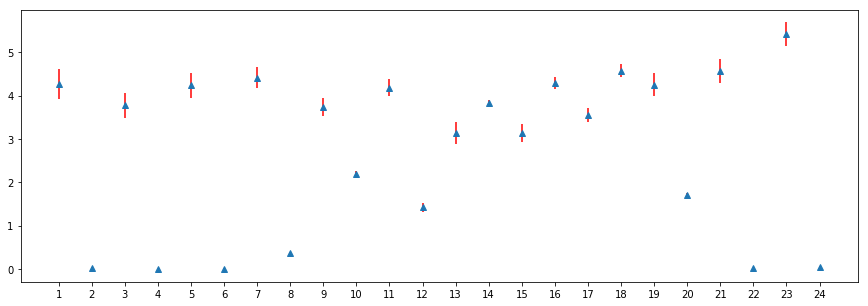

In [117]:
index=5
plt.figure(figsize=(15, 5))
plt.errorbar(x_idx, df_T.loc[index], df_T[index:10].std(),  linestyle='None', fmt='^', ecolor='r', capthick=2)
plt.xticks(x_idx)


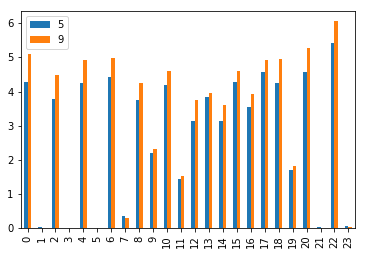

In [118]:
df_T.loc[[index, 9]].T.plot(kind='bar')